<a href="https://colab.research.google.com/github/deepakupman/dog-cat-classification/blob/master/dog_cat_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
from tqdm import tqdm_notebook
from torchvision import datasets, transforms
gpu_available = torch.cuda.is_available()
if gpu_available:
    print("Training on GPU")

Training on GPU


In [0]:
data_dir = "/content/gdrive/My Drive/dataset/cat_dog_ds"
batch_size = 32
transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

train_data = datasets.ImageFolder(data_dir + "/training_set/", transform=transform)
test_data = datasets.ImageFolder(data_dir + "/test_set/", transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [0]:
img, lbl = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


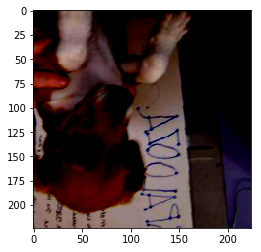

In [5]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.imshow(np.transpose(img, axes=[0,2,3,1])[0])

In [6]:
img.size()

torch.Size([32, 3, 224, 224])

In [0]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [0]:
class Model(nn.Module):
    def __init__(self):
      super().__init__()

      # convolution layers
      self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
      self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

      # pooling layer
      self.pool = nn.MaxPool2d(2,2)

      # fully connected layers
      self.fc1 = nn.Linear(128*14*14, 512)
      self.fc2 = nn.Linear(512, 256)
      
      # dropout layer
      self.dropout = nn.Dropout(0.5)

      # output layer
      self.fcf = nn.Linear(256, 2)

    def forward(self, x):
      # convolution layers
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = self.pool(F.relu(self.conv4(x)))
      # flatten the layer
      x = x.view(-1, 128*14*14)
      # fully connected layer
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x = self.fcf(x)
      return x

In [9]:
model = Model()
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
opt = optim.Adam(model.parameters(), lr=0.001)
print(model)
if gpu_available:
    model.cuda()

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.5)
  (fcf): Linear(in_features=256, out_features=2, bias=True)
)


In [10]:
# epochs
epoch = 10
train_losses = []
valid_losses = []
  
for e in range(epoch):
  
  # keep track of train and validation loss
  train_loss = 0.0
  valid_loss = 0.0
  
  # enable training mode
  model.train()
  
  # training model
  for image, label in tqdm_notebook(train_loader):
    # check for GPU
    if gpu_available:
        image, label = image.cuda(), label.cuda()
    # make gradient zero
    opt.zero_grad()
    # get output
    out = model(image)
    # calc. loss
    loss = criterion(out, label)
    # backward propagation
    loss.backward()
    # calculate gradient descent
    opt.step()
    # add train loss
    train_loss += loss.item()
  else:
    accuracy = 0
    with torch.no_grad():
      # evaluate model
      model.eval()
      # valid the model
      for img, lbl in tqdm_notebook(test_loader):
        # check for gpu
        if gpu_available:
          img, lbl = img.cuda(), lbl.cuda()
        # get output
        output = model(img)
        # calculate loss
        loss = criterion(output, lbl)
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class==lbl.view(top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        valid_loss += loss.item()
    model.train()

    # calculate average loss
    train_losses.append(train_loss/ len(train_loader))
    valid_losses.append(valid_loss / len(test_loader))
    print('Epoch: {}/{}'.format(e+1,epoch),
             'Train loss: {:.3f}'.format(train_loss/len(train_loader)),
             'Validation loss: {:.3f}'.format(valid_loss/len(test_loader)),
             'Test Accuracy: {:.3f}%'.format((accuracy/len(test_loader))*100))


Epoch: 1/10 Train loss: 0.694 Validation loss: 0.693 Test Accuracy: 49.901%



Epoch: 2/10 Train loss: 0.693 Validation loss: 0.680 Test Accuracy: 57.837%



Epoch: 3/10 Train loss: 0.671 Validation loss: 0.654 Test Accuracy: 60.119%



Epoch: 4/10 Train loss: 0.651 Validation loss: 0.623 Test Accuracy: 66.270%



Epoch: 5/10 Train loss: 0.640 Validation loss: 0.616 Test Accuracy: 65.526%



Epoch: 6/10 Train loss: 0.594 Validation loss: 0.564 Test Accuracy: 71.528%



Epoch: 7/10 Train loss: 0.566 Validation loss: 0.552 Test Accuracy: 71.478%



Epoch: 8/10 Train loss: 0.552 Validation loss: 0.548 Test Accuracy: 70.585%



Epoch: 9/10 Train loss: 0.528 Validation loss: 0.557 Test Accuracy: 70.635%



Epoch: 10/10 Train loss: 0.522 Validation loss: 0.484 Test Accuracy: 78.472%


**Predict the output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor(68.7500)


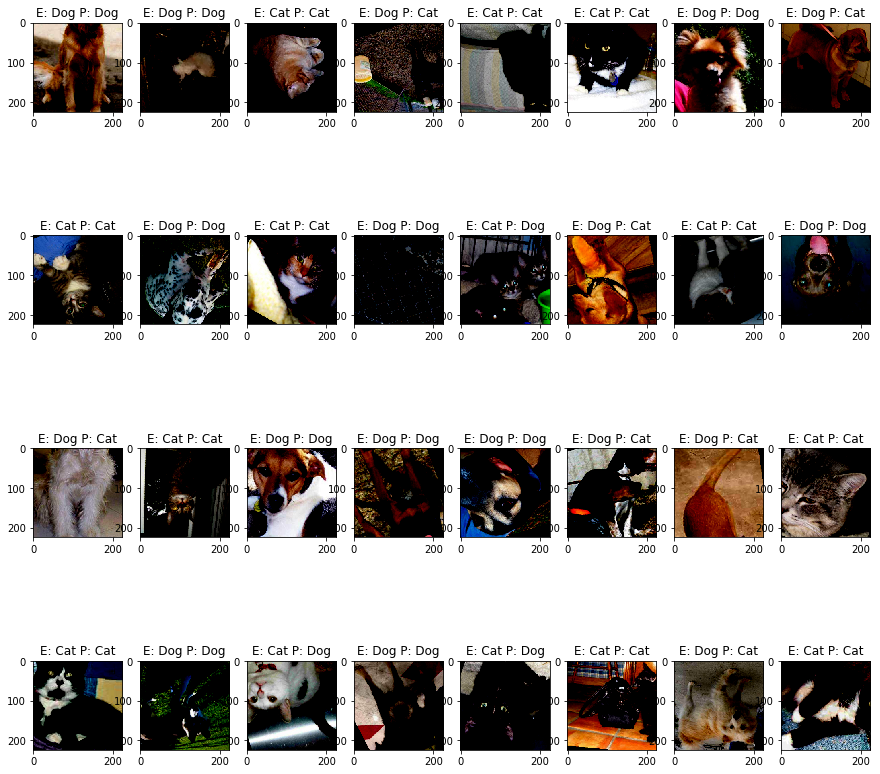

In [16]:
name = lambda x: "Dog" if x.data == 1 else "Cat"
def predict(image, label):
  # output from network
  out = model(image.cuda())
  # get top k(k=1) classes with probability
  top_p, top_class = out.topk(1, dim=1)
  # compare expected value and predicted value
  equals = top_class==label.cuda().view(top_class.shape)
  accuracy = torch.mean(equals.type(torch.FloatTensor))
  # plot subplot for all batch images
  fig = plt.figure(figsize=(15, 15))
  for i in range(32):
    ax = fig.add_subplot(4, 8, i+1, title="E: " + name(label[i]) + " P: " + name(top_class[i]))
    ax.imshow(np.transpose(image, axes=[0,2,3,1])[i])
  # print accuracy for batch
  print(accuracy.data * 100)

# predict the output for batch
image, label = next(iter(test_loader))
predict(image, label)

**Plot training loss and validation loss**

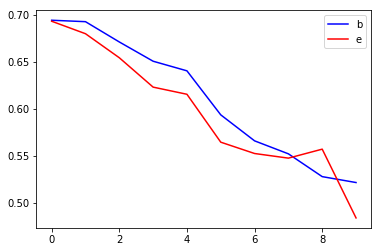

In [14]:
plt.plot(range(10), train_losses, '-b', label="train loss")
plt.plot(range(10), valid_losses, '-r', label="validation loss")
plt.legend('best')